In [2]:
import numpy as np
import matplotlib.pyplot as plt
from regions import Regions
import regions
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.modeling import models, fitting

from dust_extinction.averages import CT06_MWGC

from smart_plotters.jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
from smart_plotters.cutout_plot import get_cutout_405, get_cutout_jwst_ice
import smart_plotters.co_ice as co_map
from smart_plotters import cmd_plot 

In [3]:
cat_use = make_cat_use()

In [4]:
def get_rc_sel_mask(cat):
    x = np.linspace(0, 2.5, 10)
    
    x0 = 0.52
    mask_x0_left = cat.color('f182m', 'f212n') > x0

    y0 = 14.8
    mask_above_y0 = cat.band('f182m') > y0
    mask_rc = mask_above_y0 & mask_x0_left

    pt1 = (0.5, 14.3)
    pt2 = (2.0, 20.)
    y1 = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (x - pt1[0]) + pt1[1]
    mask_below_y1 = cat.band('f182m') > ( (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (cat.color('f182m', 'f212n') - pt1[0]) + pt1[1] )
    mask_rc = mask_below_y1 & mask_rc

    pt1 = (0.5, 15.5)
    pt2 = (2.0, 20.9)
    y2 = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (x - pt1[0]) + pt1[1]
    mask_above_y2 = cat.band('f182m') < ( (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (cat.color('f182m', 'f212n') - pt1[0]) + pt1[1] )
    mask_rc = mask_rc & mask_above_y2

    return mask_rc

In [5]:
cat_rc = JWSTCatalog(cat_use.catalog[get_rc_sel_mask(cat_use)])

In [6]:
fn = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits'
hdu = fits.open(fn)
ww = WCS(hdu['SCI'].header)
nanfield = np.nan * hdu['SCI'].data

In [7]:
reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')
reg_b = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudb.region')
reg_c1 = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/cloudc1_ice.reg')
reg_c2 = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/cloudc2_ice.reg')
reg_d = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/cloudd_ice.reg')
reg_fil_r = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_right.region')
reg_left_cd = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/left_cloudd.region')
reg_c_n = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudc_north.region')
reg_c_s = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudc_south.region')

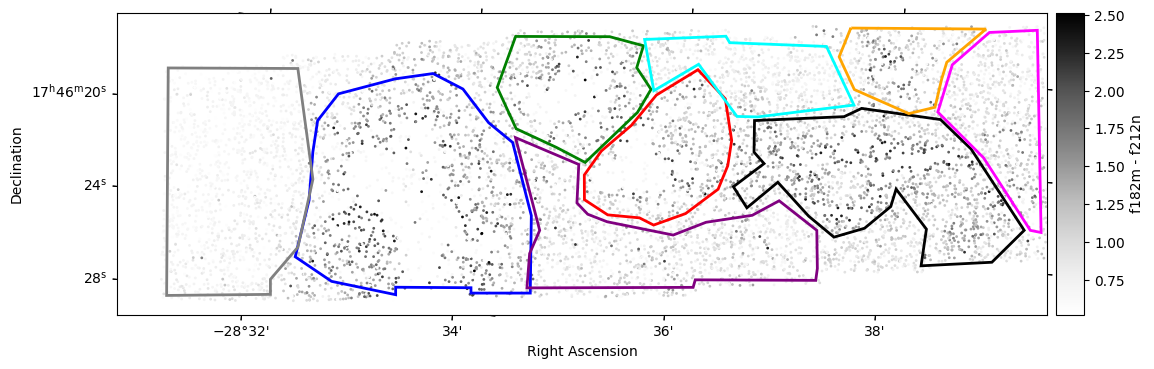

In [8]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ww)
ax.imshow(nanfield)
cat_rc.plot_position(s=1, c=cat_rc.color('f182m', 'f212n'), cmap='Greys', transform=ax.get_transform('world'))
cax = ax.inset_axes([1.01, 0., 0.03, 1])
plt.colorbar(ax.collections[0], cax=cax, orientation='vertical', label='f182m - f212n')

reg_f[0].to_pixel(ww).plot(ax=ax, edgecolor='k', facecolor='none', lw=2)
reg_c1[0].to_pixel(ww).plot(ax=ax, edgecolor='r', facecolor='none', lw=2)
reg_c2[0].to_pixel(ww).plot(ax=ax, edgecolor='g', facecolor='none', lw=2)
reg_d[0].to_pixel(ww).plot(ax=ax, edgecolor='b', facecolor='none', lw=2)
reg_b[0].to_pixel(ww).plot(ax=ax, edgecolor='orange', facecolor='none', lw=2)
reg_fil_r[0].to_pixel(ww).plot(ax=ax, edgecolor='magenta', facecolor='none', lw=2)
reg_left_cd[0].to_pixel(ww).plot(ax=ax, edgecolor='grey', facecolor='none', lw=2)
reg_c_s[0].to_pixel(ww).plot(ax=ax, edgecolor='purple', facecolor='none', lw=2)
reg_c_n[0].to_pixel(ww).plot(ax=ax, edgecolor='cyan', facecolor='none', lw=2)

# RC Only

In [9]:
cat_f_rc = JWSTCatalog(cat_rc.table_region_mask(reg_f, ww))
cat_c1_rc = JWSTCatalog(cat_rc.table_region_mask(reg_c1, ww))
cat_c2_rc = JWSTCatalog(cat_rc.table_region_mask(reg_c2, ww))
cat_d_rc = JWSTCatalog(cat_rc.table_region_mask(reg_d, ww))
cat_b_rc = JWSTCatalog(cat_rc.table_region_mask(reg_b, ww))
cat_fil_r_rc = JWSTCatalog(cat_rc.table_region_mask(reg_fil_r, ww))
cat_left_cd_rc = JWSTCatalog(cat_rc.table_region_mask(reg_left_cd, ww))
cat_c_n_rc = JWSTCatalog(cat_rc.table_region_mask(reg_c_n, ww))
cat_c_s_rc = JWSTCatalog(cat_rc.table_region_mask(reg_c_s, ww))

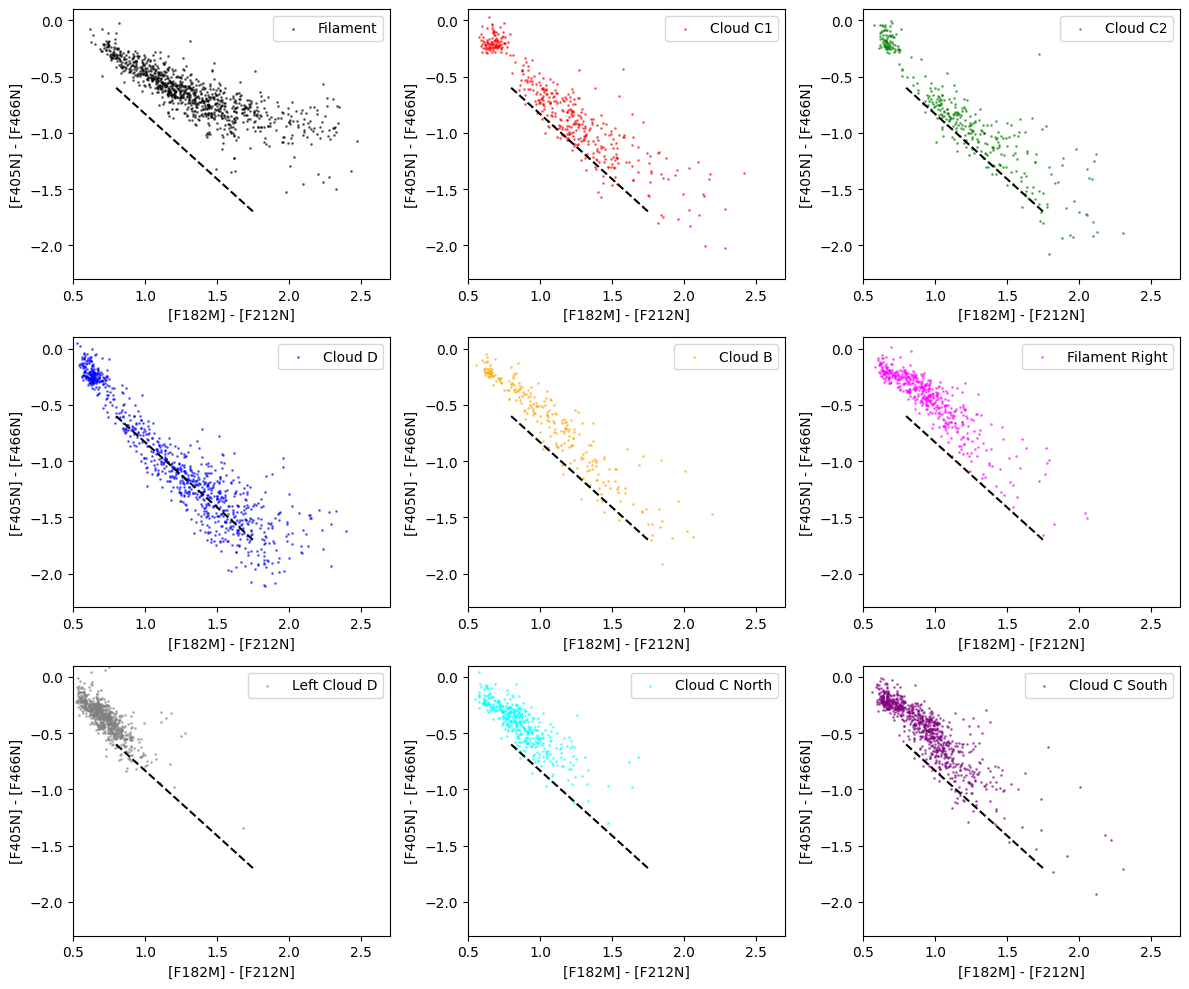

In [10]:
fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(331)
cat_f_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax1, s=1, alpha=0.5, label='Filament', color='k')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax1.set_xlim(0.5, 2.7)
ax1.set_ylim(-2.3, 0.1)
plt.legend()

ax2 = plt.subplot(332)
cat_c1_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax2, s=1, alpha=0.5, label='Cloud C1', color='r')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax2.set_xlim(0.5, 2.7)
ax2.set_ylim(-2.3, 0.1)
plt.legend()

ax3 = plt.subplot(333)
cat_c2_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax3, s=1, alpha=0.5, label='Cloud C2', color='g')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax3.set_xlim(0.5, 2.7)
ax3.set_ylim(-2.3, 0.1)
plt.legend()

ax4 = plt.subplot(334)
cat_d_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax4, s=1, alpha=0.5, label='Cloud D', color='b')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax4.set_xlim(0.5, 2.7)
ax4.set_ylim(-2.3, 0.1)
plt.legend()

ax5 = plt.subplot(335)
cat_b_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax5, s=1, alpha=0.5, label='Cloud B', color='orange')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax5.set_xlim(0.5, 2.7)
ax5.set_ylim(-2.3, 0.1)
plt.legend()

ax6 = plt.subplot(336)
cat_fil_r_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax6, s=1, alpha=0.5, label='Filament Right', color='magenta')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax6.set_xlim(0.5, 2.7)
ax6.set_ylim(-2.3, 0.1)
plt.legend()

ax7 = plt.subplot(337)
cat_left_cd_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax7, s=1, alpha=0.5, label='Left Cloud D', color='grey')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax7.set_xlim(0.5, 2.7)
ax7.set_ylim(-2.3, 0.1)
plt.legend()

ax8 = plt.subplot(338)
cat_c_n_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax8, s=1, alpha=0.5, label='Cloud C North', color='cyan')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax8.set_xlim(0.5, 2.7)
ax8.set_ylim(-2.3, 0.1)
plt.legend()

ax9 = plt.subplot(339)
cat_c_s_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax9, s=1, alpha=0.5, label='Cloud C South', color='purple')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax9.set_xlim(0.5, 2.7)
ax9.set_ylim(-2.3, 0.1)
plt.legend()

plt.tight_layout()

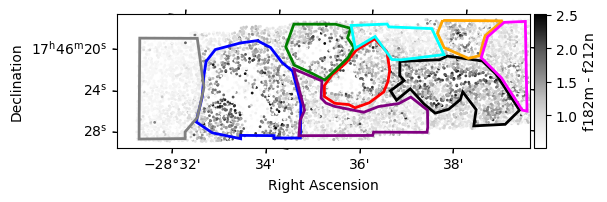

In [11]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(411, projection=ww)
ax.imshow(nanfield)
cat_rc.plot_position(s=1, c=cat_rc.color('f182m', 'f212n'), cmap='Greys', transform=ax.get_transform('world'))
cax = ax.inset_axes([1.01, 0., 0.03, 1])
plt.colorbar(ax.collections[0], cax=cax, orientation='vertical', label='f182m - f212n')

reg_f[0].to_pixel(ww).plot(ax=ax, edgecolor='k', facecolor='none', lw=2)
reg_c1[0].to_pixel(ww).plot(ax=ax, edgecolor='r', facecolor='none', lw=2)
reg_c2[0].to_pixel(ww).plot(ax=ax, edgecolor='g', facecolor='none', lw=2)
reg_d[0].to_pixel(ww).plot(ax=ax, edgecolor='b', facecolor='none', lw=2)
reg_b[0].to_pixel(ww).plot(ax=ax, edgecolor='orange', facecolor='none', lw=2)
reg_fil_r[0].to_pixel(ww).plot(ax=ax, edgecolor='magenta', facecolor='none', lw=2)
reg_left_cd[0].to_pixel(ww).plot(ax=ax, edgecolor='grey', facecolor='none', lw=2)
reg_c_s[0].to_pixel(ww).plot(ax=ax, edgecolor='purple', facecolor='none', lw=2)
reg_c_n[0].to_pixel(ww).plot(ax=ax, edgecolor='cyan', facecolor='none', lw=2)

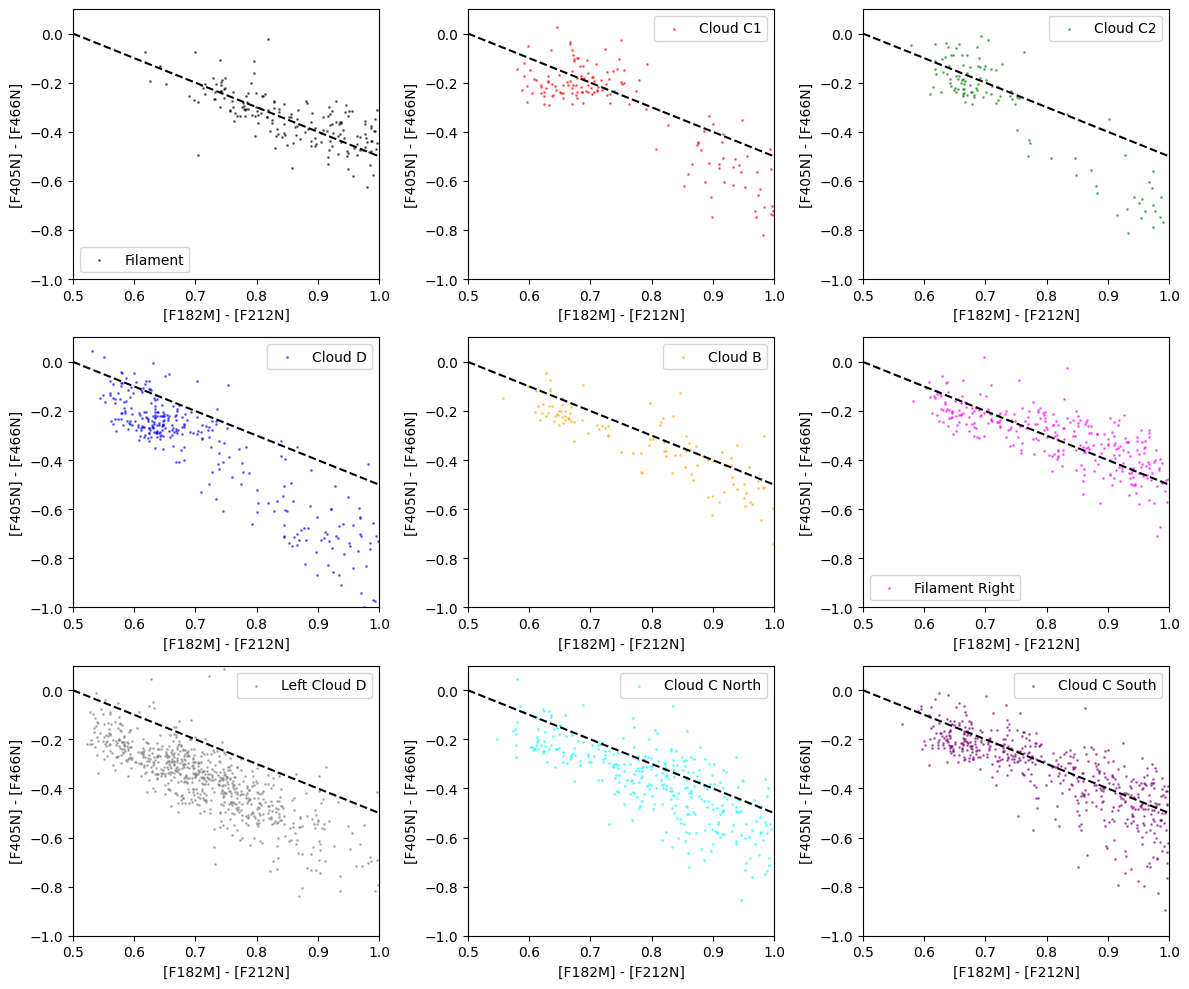

In [12]:
fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(331)
cat_f_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax1, s=1, alpha=0.5, label='Filament', color='k')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax1.set_xlim(0.5, 1)
ax1.set_ylim(-1, 0.1)
plt.legend()

ax2 = plt.subplot(332)
cat_c1_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax2, s=1, alpha=0.5, label='Cloud C1', color='r')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax2.set_xlim(0.5, 1)
ax2.set_ylim(-1, 0.1)
plt.legend()

ax3 = plt.subplot(333)
cat_c2_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax3, s=1, alpha=0.5, label='Cloud C2', color='g')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax3.set_xlim(0.5, 1)
ax3.set_ylim(-1, 0.1)
plt.legend()

ax4 = plt.subplot(334)
cat_d_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax4, s=1, alpha=0.5, label='Cloud D', color='b')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax4.set_xlim(0.5, 1)
ax4.set_ylim(-1, 0.1)
plt.legend()

ax5 = plt.subplot(335)
cat_b_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax5, s=1, alpha=0.5, label='Cloud B', color='orange')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax5.set_xlim(0.5, 1)
ax5.set_ylim(-1, 0.1)
plt.legend()

ax6 = plt.subplot(336)
cat_fil_r_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax6, s=1, alpha=0.5, label='Filament Right', color='magenta')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax6.set_xlim(0.5, 1)
ax6.set_ylim(-1, 0.1)
plt.legend()

ax7 = plt.subplot(337)
cat_left_cd_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax7, s=1, alpha=0.5, label='Left Cloud D', color='grey')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax7.set_xlim(0.5, 1)
ax7.set_ylim(-1, 0.1)
plt.legend()

ax8 = plt.subplot(338)
cat_c_n_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax8, s=1, alpha=0.5, label='Cloud C North', color='cyan')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax8.set_xlim(0.5, 1)
ax8.set_ylim(-1, 0.1)
plt.legend()

ax9 = plt.subplot(339)
cat_c_s_rc.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax9, s=1, alpha=0.5, label='Cloud C South', color='purple')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax9.set_xlim(0.5, 1)
ax9.set_ylim(-1, 0.1)
plt.legend()

plt.tight_layout()

# Whole Catalog

In [13]:
cat_f = JWSTCatalog(cat_use.table_region_mask(reg_f, ww))
cat_c1 = JWSTCatalog(cat_use.table_region_mask(reg_c1, ww))
cat_c2 = JWSTCatalog(cat_use.table_region_mask(reg_c2, ww))
cat_d = JWSTCatalog(cat_use.table_region_mask(reg_d, ww))
cat_b = JWSTCatalog(cat_use.table_region_mask(reg_b, ww))
cat_fil_r = JWSTCatalog(cat_use.table_region_mask(reg_fil_r, ww))
cat_left_cd = JWSTCatalog(cat_use.table_region_mask(reg_left_cd, ww))
cat_c_n = JWSTCatalog(cat_use.table_region_mask(reg_c_n, ww))
cat_c_s = JWSTCatalog(cat_use.table_region_mask(reg_c_s, ww))

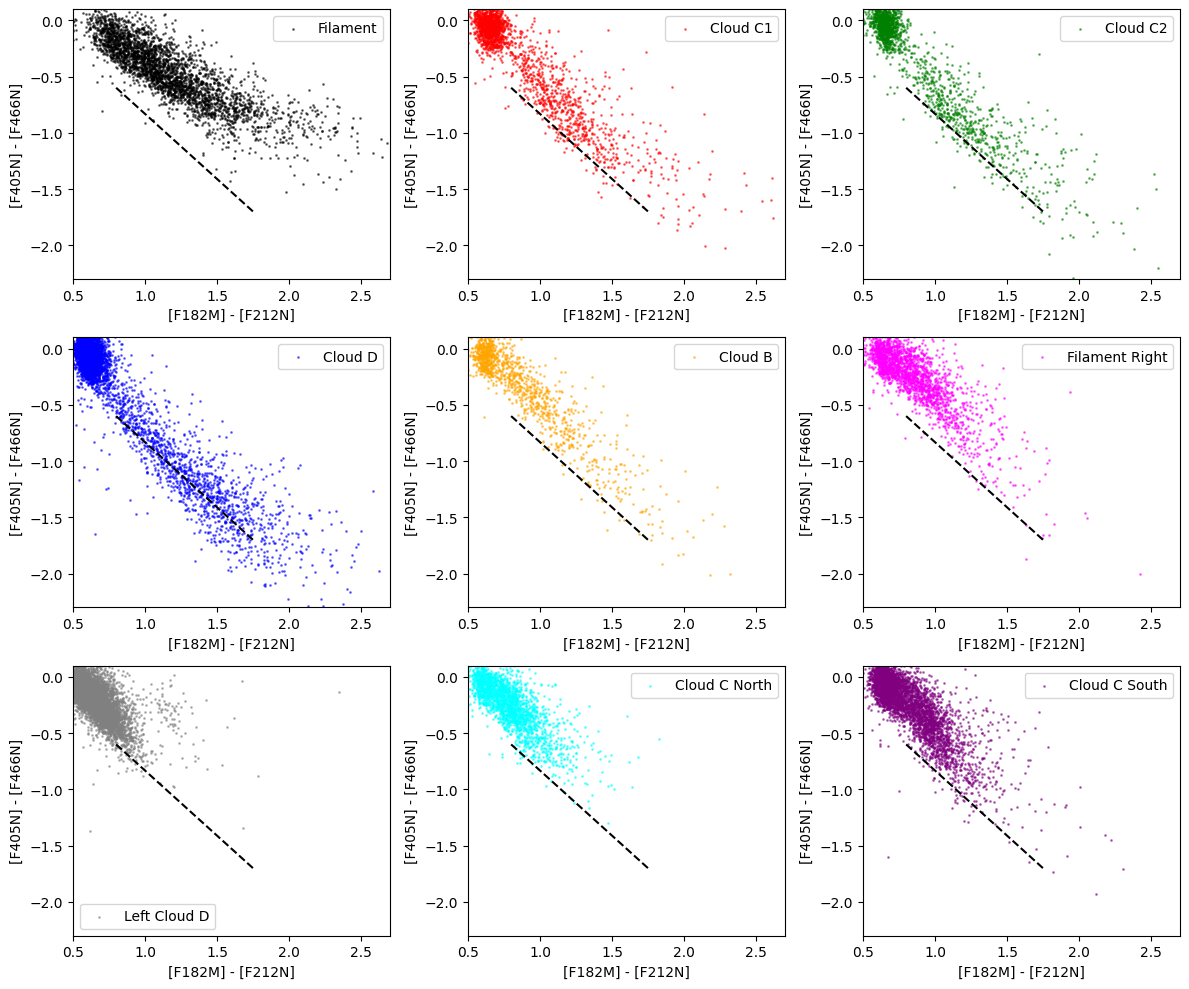

In [14]:
fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(331)
cat_f.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax1, s=1, alpha=0.5, label='Filament', color='k')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax1.set_xlim(0.5, 2.7)
ax1.set_ylim(-2.3, 0.1)
plt.legend()

ax2 = plt.subplot(332)
cat_c1.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax2, s=1, alpha=0.5, label='Cloud C1', color='r')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax2.set_xlim(0.5, 2.7)
ax2.set_ylim(-2.3, 0.1)
plt.legend()

ax3 = plt.subplot(333)
cat_c2.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax3, s=1, alpha=0.5, label='Cloud C2', color='g')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax3.set_xlim(0.5, 2.7)
ax3.set_ylim(-2.3, 0.1)
plt.legend()

ax4 = plt.subplot(334)
cat_d.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax4, s=1, alpha=0.5, label='Cloud D', color='b')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax4.set_xlim(0.5, 2.7)
ax4.set_ylim(-2.3, 0.1)
plt.legend()

ax5 = plt.subplot(335)
cat_b.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax5, s=1, alpha=0.5, label='Cloud B', color='orange')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax5.set_xlim(0.5, 2.7)
ax5.set_ylim(-2.3, 0.1)
plt.legend()

ax6 = plt.subplot(336)
cat_fil_r.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax6, s=1, alpha=0.5, label='Filament Right', color='magenta')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax6.set_xlim(0.5, 2.7)
ax6.set_ylim(-2.3, 0.1)
plt.legend()

ax7 = plt.subplot(337)
cat_left_cd.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax7, s=1, alpha=0.5, label='Left Cloud D', color='grey')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax7.set_xlim(0.5, 2.7)
ax7.set_ylim(-2.3, 0.1)
plt.legend()

ax8 = plt.subplot(338)
cat_c_n.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax8, s=1, alpha=0.5, label='Cloud C North', color='cyan')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax8.set_xlim(0.5, 2.7)
ax8.set_ylim(-2.3, 0.1)
plt.legend()

ax9 = plt.subplot(339)
cat_c_s.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax9, s=1, alpha=0.5, label='Cloud C South', color='purple')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax9.set_xlim(0.5, 2.7)
ax9.set_ylim(-2.3, 0.1)
plt.legend()

plt.tight_layout()

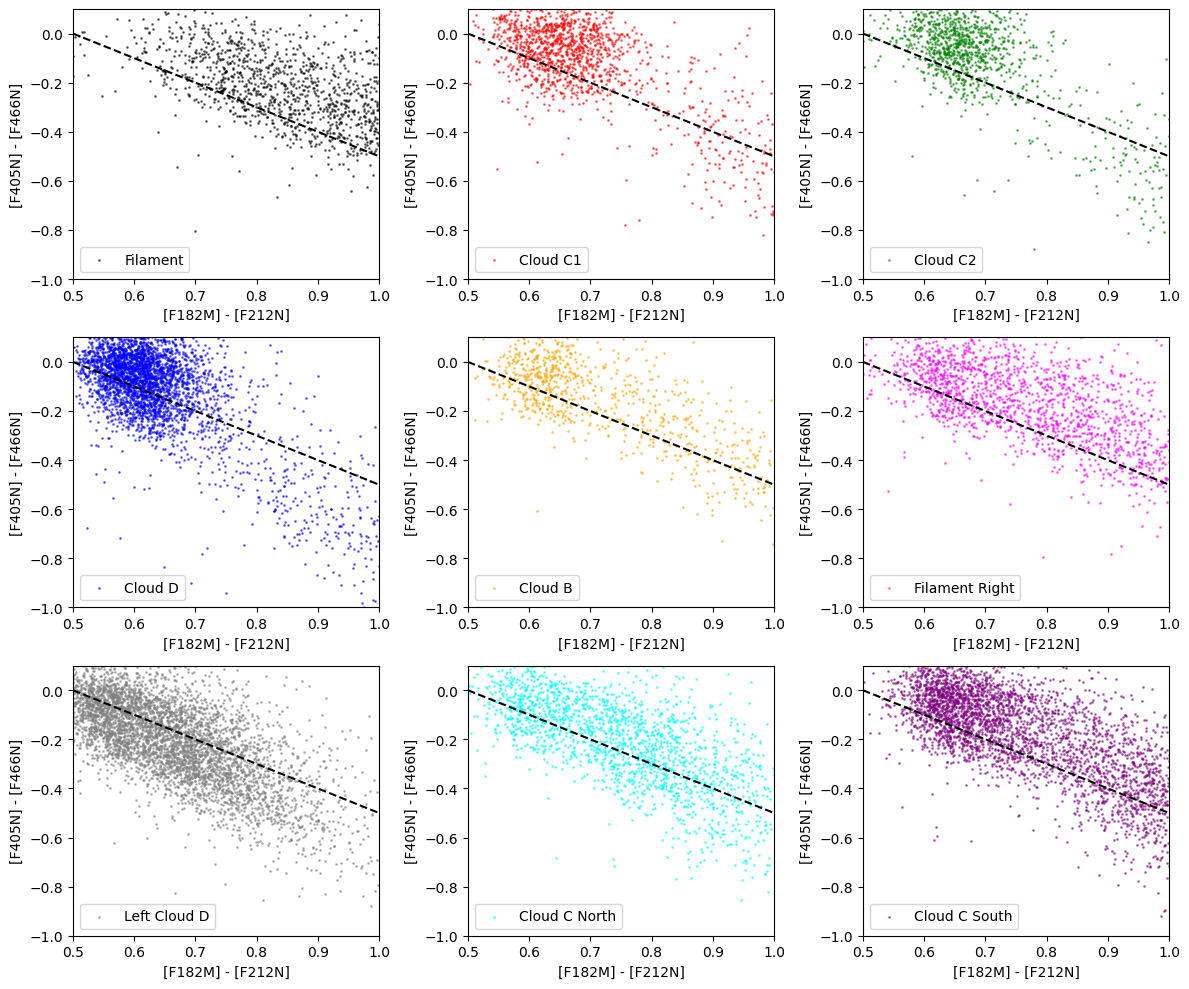

In [15]:
fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(331)
cat_f.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax1, s=1, alpha=0.5, label='Filament', color='k')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax1.set_xlim(0.5, 1)
ax1.set_ylim(-1, 0.1)
plt.legend()

ax2 = plt.subplot(332)
cat_c1.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax2, s=1, alpha=0.5, label='Cloud C1', color='r')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax2.set_xlim(0.5, 1)
ax2.set_ylim(-1, 0.1)
plt.legend()

ax3 = plt.subplot(333)
cat_c2.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax3, s=1, alpha=0.5, label='Cloud C2', color='g')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax3.set_xlim(0.5, 1)
ax3.set_ylim(-1, 0.1)
plt.legend()

ax4 = plt.subplot(334)
cat_d.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax4, s=1, alpha=0.5, label='Cloud D', color='b')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax4.set_xlim(0.5, 1)
ax4.set_ylim(-1, 0.1)
plt.legend()

ax5 = plt.subplot(335)
cat_b.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax5, s=1, alpha=0.5, label='Cloud B', color='orange')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax5.set_xlim(0.5, 1)
ax5.set_ylim(-1, 0.1)
plt.legend()

ax6 = plt.subplot(336)
cat_fil_r.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax6, s=1, alpha=0.5, label='Filament Right', color='magenta')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax6.set_xlim(0.5, 1)
ax6.set_ylim(-1, 0.1)
plt.legend()

ax7 = plt.subplot(337)
cat_left_cd.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax7, s=1, alpha=0.5, label='Left Cloud D', color='grey')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax7.set_xlim(0.5, 1)
ax7.set_ylim(-1, 0.1)
plt.legend()

ax8 = plt.subplot(338)
cat_c_n.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax8, s=1, alpha=0.5, label='Cloud C North', color='cyan')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax8.set_xlim(0.5, 1)
ax8.set_ylim(-1, 0.1)
plt.legend()

ax9 = plt.subplot(339)
cat_c_s.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', ax=ax9, s=1, alpha=0.5, label='Cloud C South', color='purple')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
ax9.set_xlim(0.5, 1)
ax9.set_ylim(-1, 0.1)
plt.legend()

plt.tight_layout()